Feature Preparation for **Customer Segmentation** application

1. Since we will categorize customers according to demographic and behavioral data, let's select and prepare the appropriate columns.

In [66]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [67]:
# load data
df = pd.read_csv('../../data/H2.csv')

---

In [68]:
# Handle Missing Values First
# Handle missing values
df['Children'].fillna(0, inplace=True)  # Fill missing 'Children' with 0
df['Country'].fillna('Unknown', inplace=True)  # Fill missing 'Country' with 'Unknown'

# adults, babies and children cant be zero at same time
print(df[(df['Adults'] == 0) & (df['Babies'] == 0) & (df['Children'] == 0)].shape[0])   # 159 rows
# Drop rows where adults, babies and children are zero at the same time
df = df[(df['Adults'] != 0) | (df['Babies'] != 0) | (df['Children'] != 0)] 

167


---

Let's first view Generally Important and Unimportant Variables

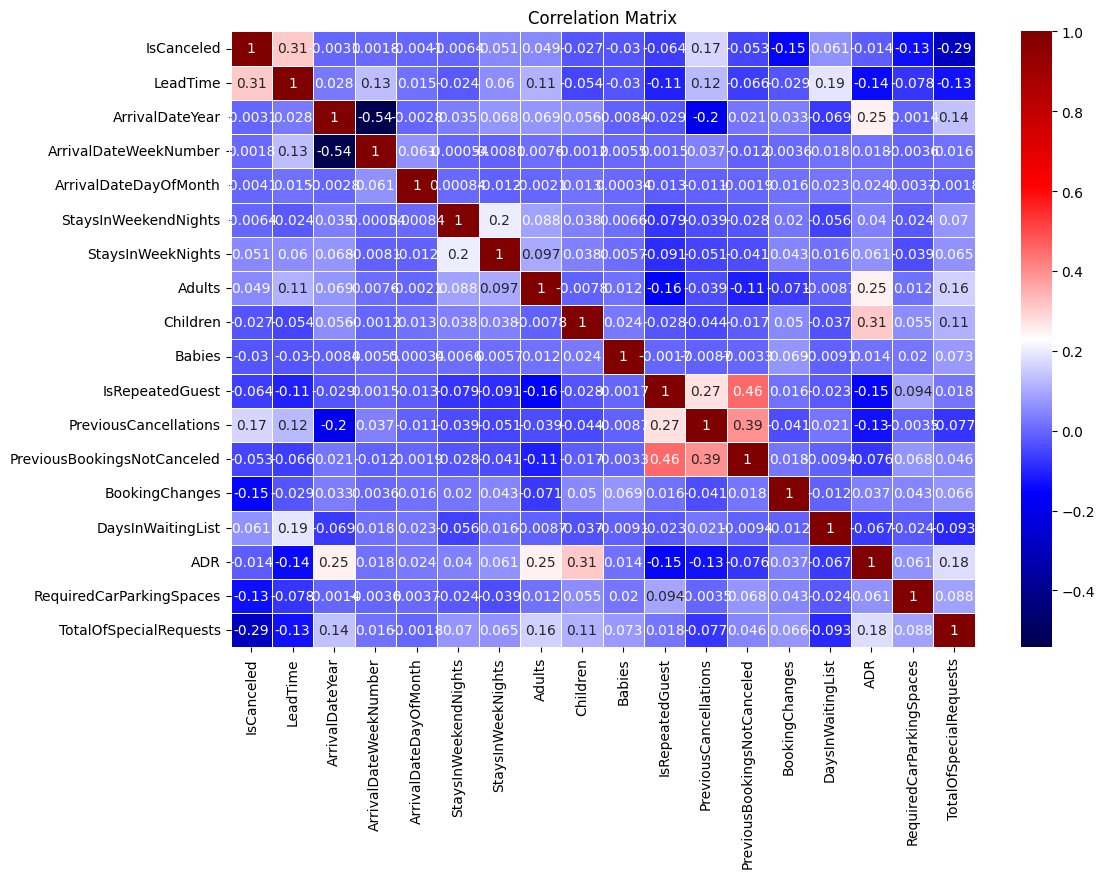

In [69]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', linewidths=.5)
plt.title('Correlation Matrix')

plt.show()

In [70]:
corr_matrix['IsCanceled'].abs().sort_values(ascending=False)  

IsCanceled                     1.000000
LeadTime                       0.308783
TotalOfSpecialRequests         0.294250
PreviousCancellations          0.166679
BookingChanges                 0.150418
RequiredCarParkingSpaces       0.133187
IsRepeatedGuest                0.063538
DaysInWaitingList              0.060929
PreviousBookingsNotCanceled    0.053133
StaysInWeekNights              0.050931
Adults                         0.049442
Babies                         0.030282
Children                       0.027407
ADR                            0.014492
StaysInWeekendNights           0.006434
ArrivalDateDayOfMonth          0.004140
ArrivalDateYear                0.003093
ArrivalDateWeekNumber          0.001797
Name: IsCanceled, dtype: float64

**Behavioral Data:**
- `LeadTime`: The time between booking and check-in date. Long-term planners and last-minute bookers can be different segments.
- `StaysInWeekendNights` and `StaysInWeekNights`: Weekend and weekday stay nights. Used to differentiate between holiday customers and business travelers.
- `TotalOfSpecialRequests`: Number of special requests. Customers with more special requests may have different expectations.
- `ADR` (Average Daily Rate): Average daily room rate. A critical variable to understand spending capacities.

**Demographic Data:**
- `Adults`, `Children`, `Babies`: Can be used to differentiate between family, individual or group customers.
- `Country`: Can show differences between international customers and local customers.

**Categorical Variables That Can Be Used for Segmentation:**
- `MarketSegment`: How customers made the reservation (e.g. Online TA, Offline TA/TO, etc.).
- `CustomerType`: Customer type (e.g. Transient, Contract etc.).
- `Meal`: Customer's meal package preference.
- `DepositType`: Deposit status (No Deposit,Non Refund or Refundable).

**Columns That Can Be Removed:**
- **Reservation Result Related:** `IsCanceled`, `ReservationStatus`, `ReservationStatusDate`.
- **Dates**: `ArrivalDateYear`, `ArrivalDateMonth`, `ArrivalDateWeekNumber`, `ArrivalDateDayOfMonth`.
- **Unnecessary or Uniform Data:** For example, `Company` or columns that are mostly empty.

1. First let's remove unimportant columns

In [71]:
# Columns to drop from the dataset
columns_to_drop = [
    'IsCanceled', 
    'ReservationStatus', 
    'ReservationStatusDate', 
    'ArrivalDateYear', 
    'ArrivalDateMonth', 
    'ArrivalDateWeekNumber', 
    'ArrivalDateDayOfMonth', 
    'Company'
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Display the first few rows of the updated dataset
df.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,6,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,0.0,0,0
1,88,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.5,0,1
2,65,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,68.0,0,1
3,92,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.5,0,2
4,100,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.5,0,1


2. Create Usefull Features

- `TotalStay` = `StaysInWeekendNights` + `StaysInWeekNights`
    - Total number of nights the customer stayed. Those who stay longer usually spend more or may need different services..
- `SpendingPerPerson` = `ADR` / (`Adults` + `Children` + `Babies`)
    - Shows the customer's spending capacity per person. Can be used to identify customers who tend to consume luxury.
- `GroupType` =
    - *Single*: `Adults` == 1 and `Children` + `Babies` == 0
    - *Couple*: `Adults` == 2 and `Children` + `Babies` == 0
    - *Family*: `Children` + `Babies` > 0
    - *Big_Group*: `Adults` > 2
        - Can be used to understand the structure of customer groups.
- `BookingUrgency` =
    - *Early_Booking*: `LeadTime` > 60
    - *Medium_Term_Booking*: 30 <= `LeadTime` <= 60
    - *Last_Minute_Booking*: `LeadTime` < 30
        - Last minute booking customers generally do not compromise on flexibility and may not be stuck with a certain price threshold.
- `HighDemand` =
    - *High* (>=2 `TotalOfSpecialRequests`)
    - *Low* (<2 `TotalOfSpecialRequests`)
        - Customers with more special requests can expect more personalized service.
- `LoyaltyScore` = `IsRepeatedGuest` × (`PreviousBookingsNotCanceled` + 1)
    - Expresses customer loyalty with a numerical metric.
- `ChildRatio` = (`Children` + `Babies`) / (`Adults` + `Children` + `Babies`)
    - An ideal metric for child-focused services or campaigns.
- `Occupancy` = (`Adults` + `Children` + `Babies`) / `TotalStay`
    - Can be used to understand the density and occupancy rate of rooms.
- `WaitingTimeCategory` = 
    - *Short* (<7 days `DaysInWaitingList`)
    - *Medium* (7-30 days `DaysInWaitingList`)
    - *Long* (>30 days `DaysInWaitingList`)
        - It can be used to identify behavioral differences in customers waiting for long periods of time.
- `CancellationRisk` = `PreviousCancellations` × `LeadTime`
    - Generates a score that measures the cancellation risk of the customer.

In [72]:
# TotalStay: Total number of nights the customer stayed
df["TotalStay"] = df["StaysInWeekendNights"] + df["StaysInWeekNights"]

# SpendingPerPerson: Customer's spending capacity per person
df["SpendingPerPerson"] = df["ADR"] / (df["Adults"] + df["Children"] + df["Babies"])
df["SpendingPerPerson"].fillna(0, inplace=True)  # Handle division by zero


# GroupType: Structure of customer groups
def determine_group_type(row):
    if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
        return "Single"
    elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
        return "Couple"
    elif (row["Children"] + row["Babies"]) > 0:
        return "Family"
    elif row["Adults"] > 2:
        return "Big_Group"
    else:
        return "Other"


df["GroupType"] = df.apply(determine_group_type, axis=1)


# BookingUrgency: Categorize bookings by lead time
def determine_booking_urgency(lead_time):
    if lead_time > 60:
        return "Early_Booking"
    elif 30 <= lead_time <= 60:
        return "Medium_Term_Booking"
    else:
        return "Last_Minute_Booking"


df["BookingUrgency"] = df["LeadTime"].apply(determine_booking_urgency)

# HighDemand: Categorize customers based on special requests
df["HighDemand"] = df["TotalOfSpecialRequests"].apply(
    lambda x: "High" if x >= 2 else "Low"
)

# LoyaltyScore: Numerical representation of customer loyalty
df["LoyaltyScore"] = df["IsRepeatedGuest"] * (df["PreviousBookingsNotCanceled"] + 1)

# ChildRatio: Ratio of children to total group size
df["ChildRatio"] = (df["Children"] + df["Babies"]) / (
    df["Adults"] + df["Children"] + df["Babies"]
)
df["ChildRatio"].fillna(0, inplace=True)  # Handle division by zero

# Occupancy: Density and occupancy rate of rooms
df["Occupancy"] = (df["Adults"] + df["Children"] + df["Babies"]) / df["TotalStay"]
df["Occupancy"].fillna(0, inplace=True)  # Handle division by zero


# WaitingTimeCategory: Categorize customers based on waiting time
def determine_waiting_time_category(days):
    if days < 7:
        return "Short"
    elif 7 <= days <= 30:
        return "Medium"
    else:
        return "Long"


df["WaitingTimeCategory"] = df["DaysInWaitingList"].apply(
    determine_waiting_time_category
)

# CancellationRisk: Risk score based on previous cancellations and lead time
df["CancellationRisk"] = df["PreviousCancellations"] * df["LeadTime"]

Since the `Country` Column, which contains country codes, contains too many categories, let's reduce it to regions.

In [73]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
df["Region"] = df["Country"].map(country_to_region)

# Drop the Country column
df.drop(columns=["Country"], inplace=True)

df["Region"].value_counts()

Region
Europe           65370
South America     1949
North America     1693
Asia               569
Oceania            339
Unknown             16
Name: count, dtype: int64

The categorical variable `Agent` has a lot of unique values ​​and most of them are numbers. There is only one string named 'NULL'.
- There is blanks in data, first we will remove these.
- We can change the 'NULL' value of this variable to 0 and
- convert it to int to make it easier to deal with.

In [74]:
# Remove blank spaces from the 'Agent' column
df['Agent'] = df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Agent'] = df['Agent'].astype(int)

df['Agent'].value_counts()

Agent
9      31916
0       8080
1       7133
14      3633
7       3532
       ...  
388        1
453        1
480        1
464        1
476        1
Name: count, Length: 224, dtype: int64